# Will a business experience acheive a higher amount of reviews based on the number of transactions it provides?

> **Explain**

In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.oauth2 import service_account
from google.cloud import bigquery
import configparser

To begin we'll have to run a new sql script to get data from Big Query aside from the other data we've already serialized on our local filesystem.

In [2]:
KEY_PATH = "/mnt/c/Users/Ron/git-repos/yelp-data/gourmanddwh-f75384f95e86.json"
CREDS = service_account.Credentials.from_service_account_file(KEY_PATH)
client = bigquery.Client(credentials=CREDS, project=CREDS.project_id)


In [4]:
transactions_file = open('sql_scripts/business_transactions.sql','r')
tran_query =  transactions_file.read()

business_transactions_dataframe = (
    client.query(tran_query)
    .result()
    .to_dataframe()
)

In [9]:
business_transactions_dataframe.to_parquet('business_transactions.snappy.parquet', 'pyarrow','snappy', partition_cols=['transactions_list'])


In [14]:
holding_file = open('sql_scripts/business_daily_holding.sql')
holding_query = holding_file.read()

holding_dataframe : pd.DataFrame = (
    client.query(holding_query)
    .result()
    .to_dataframe()
)

In [15]:
holding_dataframe.to_parquet('bus_holdings.snappy.parquet', 'pyarrow','snappy', partition_cols=['CloseDate'])


In [2]:
cg_df = pd.read_parquet('cg_est', engine='pyarrow')
bh_df: pd.DataFrame = pd.read_parquet('bus_holdings.snappy.parquet', engine='pyarrow')
bus_cats_df = pd.read_parquet('bus_cats', engine='pyarrow')
bt_df = pd.read_parquet('business_transactions.snappy.parquet', engine='pyarrow')


Our new dataset aggregates the number of transactions for each business and also concatenates the ones that a business has listed with a '**,**' as a separator.\
The data was partioned which is why it is loaded in the way it was. \
Concerning the transaction values themselves there are some businesses who haven't reported any. In this case we opted to just fill in the value other but have kept their transactions count as 0.

> Note: Concerning the transactions it seems to be 0 just indicates any regular business outside of the food industry or those that require their customers to come inside to place orders and then carry their food out. For more infromation see the following on [transactions](https://www.yelp.com/developers/documentation/v3/business_search)


In [3]:
bt_df

,BusinessKey,BusinessName,transactioncounts,transactions_list
0,35,scott-street-deli-montgomery,1,delivery
1,88,satori-coffee-house-mobile,1,delivery
2,986,international-house-of-hotdogs-anchorage,1,delivery
3,1785,wills-cinnamon-shop-hot-springs-2,1,delivery
4,1821,capos-tacos-hot-springs,1,delivery
...,...,...,...,...
63312,59447,mycovios-ocean-park-2,1,restaurant_reservation
63313,32560,d-h-lescombes-winery-and-bistro-alamogordo,1,restaurant_reservation
63314,33115,medley-el-prado,1,restaurant_reservation
63315,5103,the-pullman-glenwood-springs,1,restaurant_reservation


As seen in previous analyses and just from some domain knowledge, we know that the distribution of review counts is going to be right skewed. 

In [4]:
# the values are partitioned on the close date so there is no need for us to sort the data
most_recent_bh_df = bh_df.drop_duplicates(subset='BusinessName', keep='last')


In [5]:
most_recent_bh_df = most_recent_bh_df.reset_index(drop=True)
most_recent_bh_df

,BusinessKey,BusinessName,ChainName,BusinessRating,ReviewCount,previous_review_cnt,previous_rating,abs_review_diff,abs_rating_diff,total_review_cnt_delta,total_bus_rating_delta,CloseDate
0,18065,hog-wild-pit-bar-b-q-salina,Hog Wild Pit Bar-B-Q,4.000000000,66,NaN,None,NaN,None,NaN,None,2021-12-29
1,27043,mr-bs-frozen-treats-laurel,Mr Bs Frozen Treats,5.000000000,8,NaN,None,NaN,None,NaN,None,2021-12-29
2,27040,small-coffee-big-taste-laurel-2,Small Coffee Big Taste,4.500000000,14,NaN,None,NaN,None,NaN,None,2021-12-29
3,25441,white-horse-st-cloud-2,The White Horse Restaurant & Bar,4.000000000,208,NaN,None,NaN,None,NaN,None,2021-12-29
4,53160,deutschlander-buffalo-gap-2,Deutschlander,4.000000000,37,37.0,4.000000000,0.0,0E-9,0.0,0E-9,2022-01-14
...,...,...,...,...,...,...,...,...,...,...,...,...
63312,23543,zzs-sports-bar-and-grill-adrian,ZZ's Sports Bar & Grill,3.500000000,10,10.0,3.500000000,0.0,0E-9,-60.0,0E-9,2022-02-27
63313,5467,zzzz-s-pizzzza-burlington,ZZZZ’s PIzzzza,5.000000000,1,1.0,5.000000000,0.0,0E-9,-1.0,0.500000000,2022-02-27
63314,13045,àlavita-boise-2,ÀLAVITA,4.000000000,308,309.0,4.000000000,-1.0,0E-9,55.0,-0.500000000,2022-02-27
63315,44974,ándale-caguas-2,Ándale,5.000000000,3,3.0,5.000000000,0.0,0E-9,0.0,0E-9,2022-02-27


The histogram of the data shows this as well as the kernal density estimate.

array([[<AxesSubplot:title={'center':'ReviewCount'}>]], dtype=object)

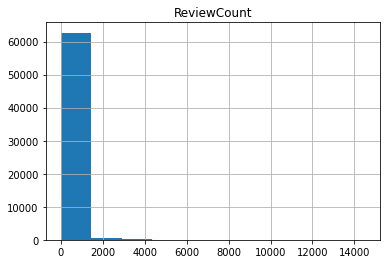

In [6]:
most_recent_bh_df.hist('ReviewCount', bins=10)

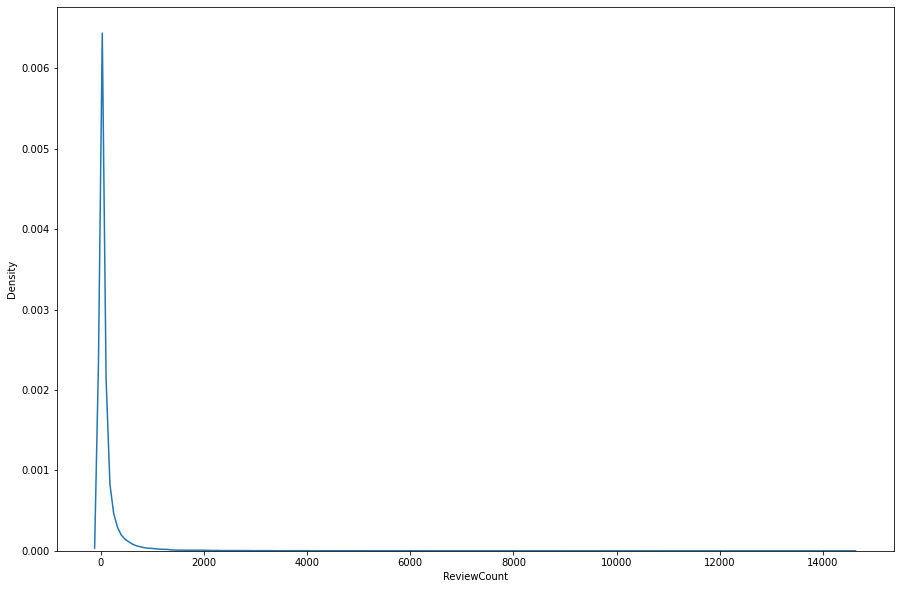

In [7]:
plt.figure(figsize=(15, 10))
sns.kdeplot(most_recent_bh_df['ReviewCount'])
plt.show()

A more granular look at the data reveals the same as well.

In [8]:
most_recent_bh_df['ReviewCount'].value_counts(normalize=True ,bins=10)

(-14.514, 1451.3]     0.989813
(1451.3, 2902.6]      0.007233
(2902.6, 4353.9]      0.001737
(4353.9, 5805.2]      0.000727
(7256.5, 8707.8]      0.000190
(5805.2, 7256.5]      0.000174
(8707.8, 10159.1]     0.000063
(10159.1, 11610.4]    0.000032
(13061.7, 14513.0]    0.000032
(11610.4, 13061.7]    0.000000
Name: ReviewCount, dtype: float64

With such skew we would ideally take some sort of transformation of this variable whether it be the natural log or some higher-order polynomial, etc.\
But before doing so it may be best to look at the joint distribtuion of our 2 variables ,namely, `transaction counts` and `review counts`.

We'll just merge out data first.

In [9]:
most_recent_bh_tran_df = pd.merge(left=most_recent_bh_df, right=bt_df, on='BusinessKey', how='inner')
most_recent_bh_tran_df.head()

,BusinessKey,BusinessName_x,ChainName,BusinessRating,ReviewCount,previous_review_cnt,previous_rating,abs_review_diff,abs_rating_diff,total_review_cnt_delta,total_bus_rating_delta,CloseDate,BusinessName_y,transactioncounts,transactions_list
0,18065,hog-wild-pit-bar-b-q-salina,Hog Wild Pit Bar-B-Q,4.000000000,66,NaN,None,NaN,None,NaN,None,2021-12-29,hog-wild-pit-bar-b-q-salina,1,delivery
1,27043,mr-bs-frozen-treats-laurel,Mr Bs Frozen Treats,5.000000000,8,NaN,None,NaN,None,NaN,None,2021-12-29,mr-bs-frozen-treats-laurel,0,other
2,27040,small-coffee-big-taste-laurel-2,Small Coffee Big Taste,4.500000000,14,NaN,None,NaN,None,NaN,None,2021-12-29,small-coffee-big-taste-laurel-2,0,other
3,25441,white-horse-st-cloud-2,The White Horse Restaurant & Bar,4.000000000,208,NaN,None,NaN,None,NaN,None,2021-12-29,white-horse-st-cloud-2,1,delivery
4,53160,deutschlander-buffalo-gap-2,Deutschlander,4.000000000,37,37.0,4.000000000,0.0,0E-9,0.0,0E-9,2022-01-14,deutschlander-buffalo-gap-2,0,other


<AxesSubplot:xlabel='transactioncounts', ylabel='ReviewCount'>

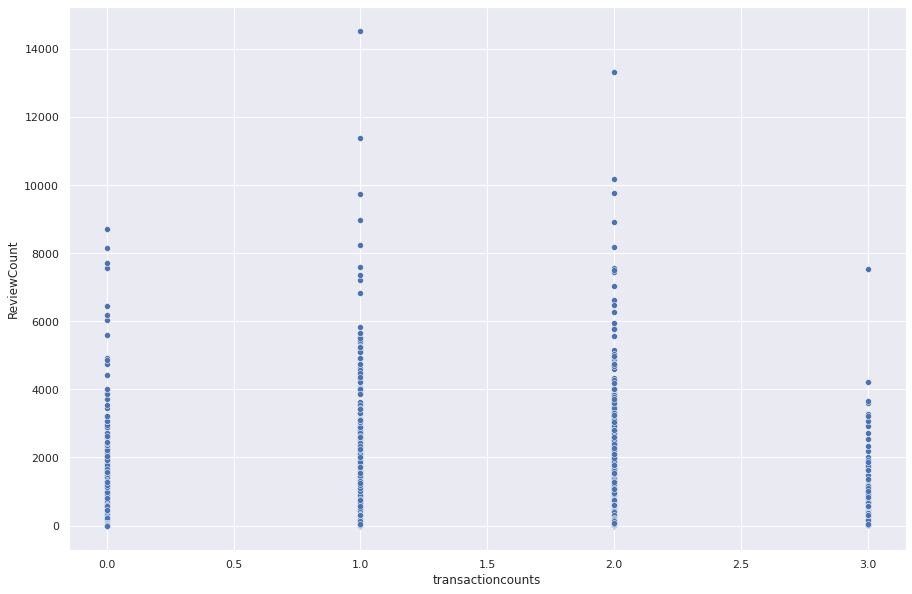

In [10]:
sns.set_theme()
plt.figure(figsize=(15, 10))
sns.scatterplot(x=most_recent_bh_tran_df['transactioncounts'], y=most_recent_bh_tran_df['ReviewCount'], x_jitter=.30)

Basándonos en esta imagen se puede ver que la mejor forma de transformar la cantidad de revistas sería tomar el polynomial, y para ser mas preciso una tranformación de la siguiente forma $$x^2$$ \
Es decir una cuadradra también esto es porque el la distribución empieza a subir y luego comienza a bajar después de llegar a una sola transacción.\
El único problema es que éste es el variable dependiente así que nos conformamos con tomar el log que tambien puede ayudar. \
El otro problema viene siendo que tambien tenemos cero en este variable.

In [11]:
most_recent_bh_df['ReviewCount'].nsmallest(10)

10853    0
23413    0
24761    0
25502    0
40924    0
51025    0
25       1
38       1
40       1
47       1
Name: ReviewCount, dtype: int64

Ya que no hay una cantidad impresionante de ceros podemos botarlos. Se puede ver que arriba solo hay seis.

In [17]:
most_recent_bh_df_sin_cero = most_recent_bh_tran_df[most_recent_bh_tran_df['ReviewCount'] > 0 ]

In [18]:
most_recent_bh_df_sin_cero.loc[:, 'ln_review_count'] = np.log(most_recent_bh_df_sin_cero['ReviewCount'])

/mnt/c/Users/Ron/git-repos/data-analysis-business-economics-policy/da_venv/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


<AxesSubplot:xlabel='transactioncounts', ylabel='ln_review_count'>

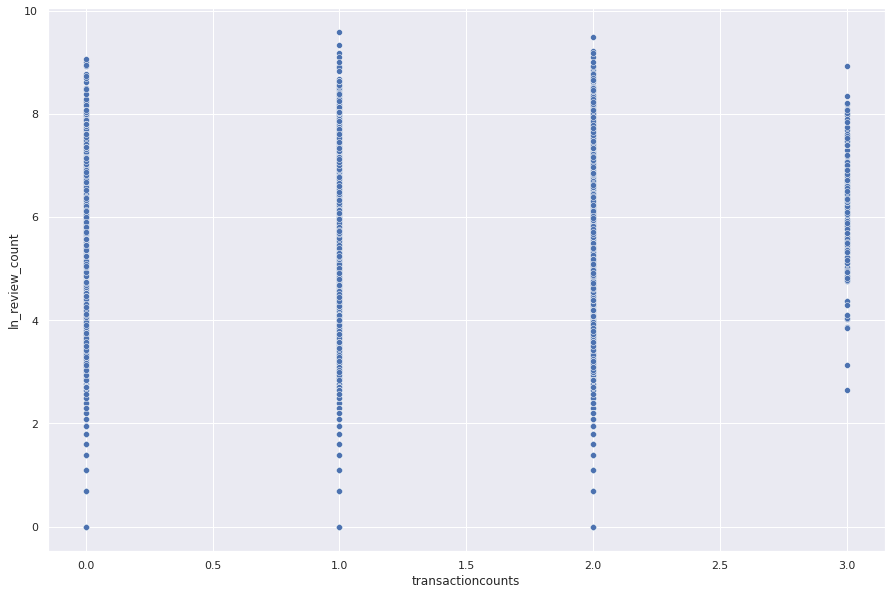

In [19]:
sns.set_theme()
plt.figure(figsize=(15, 10))
sns.scatterplot(x=most_recent_bh_df_sin_cero['transactioncounts'], y=most_recent_bh_df_sin_cero['ln_review_count'], x_jitter=.30)

Comparado con el otro gráfico vemos la diferencia entre los dos despues de la transformación.\
Ahora la mayoria de las resenas parecen mas juntas y no tan lejanas.

[Text(0.5, 1.0, 'After Transformation'), Text(0, 0.5, 'ln_review_count (ln)')]

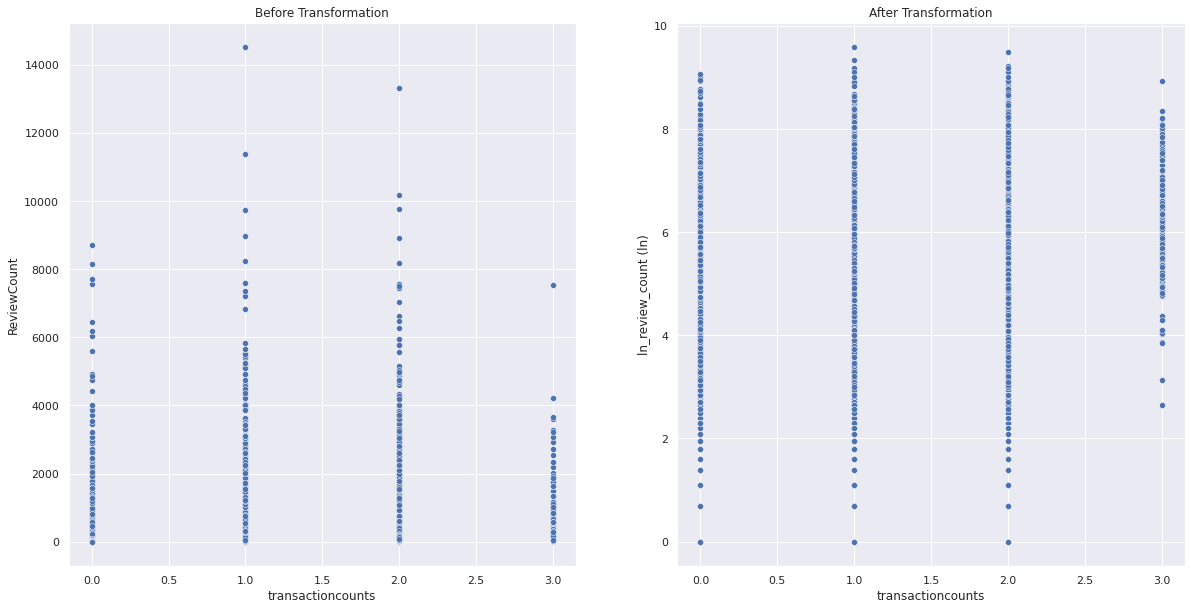

In [29]:
sns.set_theme()
fig, axes = plt.subplots(1,2, figsize=(20, 10))

sns.scatterplot(x=most_recent_bh_df_sin_cero['transactioncounts'], y=most_recent_bh_df_sin_cero['ReviewCount'], x_jitter=.30, ax=axes[0])

sns.scatterplot(x=most_recent_bh_df_sin_cero['transactioncounts'], y=most_recent_bh_df_sin_cero['ln_review_count'], x_jitter=.30,ax=axes[1] )
axes[0].set(title='Before Transformation')
axes[1].set(title='After Transformation', ylabel=f'{axes[1].get_ylabel()} (ln)')

Now we'll begin with our regression of log review counts regressed on transaction counts.

In [30]:
X_tc = most_recent_bh_df_sin_cero['transactioncounts']
X_tc_with_constant = sm.add_constant(X_tc)

y = most_recent_bh_df_sin_cero['ln_review_count']

univariate_lin_model = sm.OLS(y, X_tc_with_constant)
results = univariate_lin_model.fit(cov_type='HC1')

/mnt/c/Users/Ron/git-repos/data-analysis-business-economics-policy/da_venv/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [31]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        ln_review_count   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                 2.111e+04
Date:                Mon, 28 Feb 2022   Prob (F-statistic):               0.00
Time:                        09:30:04   Log-Likelihood:            -1.1825e+05
No. Observations:               63311   AIC:                         2.365e+05
Df Residuals:                   63309   BIC:                         2.365e+05
Df Model:                           1                                         
Covariance Type:                  HC1                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 2.6400      0.008    348.882      0.000       2.625       2.655
transactioncounts     1.2512      0.009    145.292      0.000       1.234       1.268
==============================================================================
Omnibus:                      379.277   Durbin-Watson:                   1.674
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              337.832
Skew:                           0.134   Prob(JB):                     4.37e-74
Kurtosis:                       2.763   Cond. No.                         1.91
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

For one variable (`transactioncounts`) the $$r^2$$ is pretty good.\
A natural question that would come up is how do we interpret our equation of $$y^E = 2.64 + 1.2512(x)$$ .\
In this case since we have a log - level regression the correct interpretation is for an additional unit of x ,i.e. additional transaction method, we can expect the amount of reviews to increase by 125%.
> **come back and maybe do robustness check with omission of log transformation**

Now we're going to switch to another regression that wanted to do in our first [EDA](http://localhost:8888/notebooks/nb_analysis_01.ipynb) but couldn't due to the variation in the data values.\
This is a univariate regression of `ReviewCount` conditional on `total_review_cnt_delta`.

<AxesSubplot:xlabel='total_review_cnt_delta', ylabel='ReviewCount'>

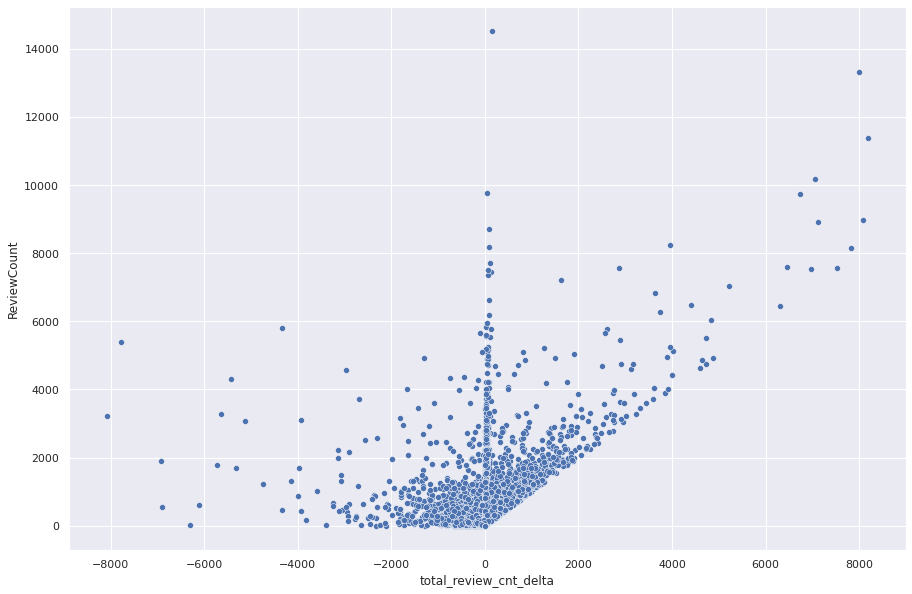

In [32]:
sns.set_theme()
plt.figure(figsize=(15, 10))
sns.scatterplot(x=most_recent_bh_df_sin_cero['total_review_cnt_delta'], y=most_recent_bh_df_sin_cero['ReviewCount'], x_jitter=.30)

<AxesSubplot:xlabel='ReviewCount', ylabel='total_review_cnt_delta'>

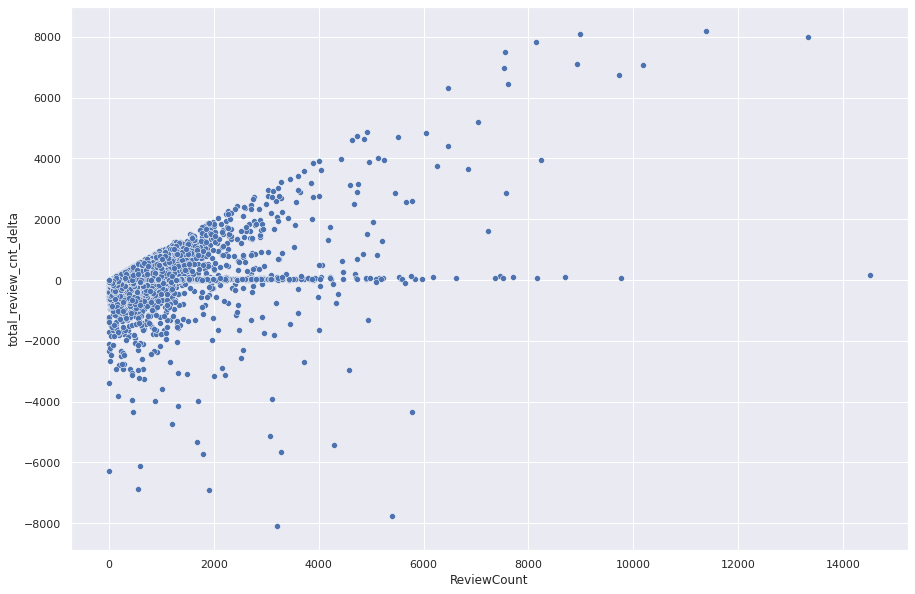

In [33]:
sns.set_theme()
plt.figure(figsize=(15, 10))
sns.scatterplot(y=most_recent_bh_df_sin_cero['total_review_cnt_delta'], x=most_recent_bh_df_sin_cero['ReviewCount'], x_jitter=.30)

Here with the last chart we can see that there are some businesses whose review counts decreased by as many as 8000 reviews. These seem like extreme values to say the least and we can actually go a bit further and say they have a high chance of being outlier based on the following [analysis](https://public.tableau.com/app/profile/ronald2610/viz/Dashboardindevelopment/FindingthesourceofExtremeValues) we did in Tableau.
Many of these values were actually due to some problem on Yelp's end.

> **explore some of these outliers here**

One option with such values is to impute 0 for their log transofrmed variable and then create a flag variable denoting whether or not the original variable was x <= 0. \
In this case we are just going to take the log of `ReviewCounts` to see the interpretation of doing a log for the explanatory variable.

First, some null values in `total_review_cnt_delta` need to dealt with but considering there are only 4 we can simply drop these.

In [36]:
most_recent_bh_df_sin_cero['total_review_cnt_delta'].isna().sum()

4

In [39]:
most_recent_bh_df_sin_cero_sin_na = most_recent_bh_df_sin_cero[~ most_recent_bh_df_sin_cero['total_review_cnt_delta'].isna()]
most_recent_bh_df_sin_cero_sin_na.shape

(63307, 16)

In [40]:
X_rc = most_recent_bh_df_sin_cero_sin_na['ln_review_count']
X_rc_with_constant = sm.add_constant(X_rc)

y2 = most_recent_bh_df_sin_cero_sin_na['total_review_cnt_delta']

univariate_lin_model_trcd_lnrc = sm.OLS(y2, X_rc_with_constant)
univariate_lin_model_trcd_lnrc_results = univariate_lin_model_trcd_lnrc.fit(cov_type='HC1')


/mnt/c/Users/Ron/git-repos/data-analysis-business-economics-policy/da_venv/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [41]:
univariate_lin_model_trcd_lnrc_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     total_review_cnt_delta   R-squared:                       0.014
Model:                                OLS   Adj. R-squared:                  0.014
Method:                     Least Squares   F-statistic:                     153.1
Date:                    Mon, 28 Feb 2022   Prob (F-statistic):           4.00e-35
Time:                            10:31:16   Log-Likelihood:            -4.3583e+05
No. Observations:                   63307   AIC:                         8.717e+05
Df Residuals:                       63305   BIC:                         8.717e+05
Df Model:                               1                                         
Covariance Type:                      HC1                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -46.7120      3.205    -14.575      0.000     -52.994     -40.430
ln_review_count    15.4866      1.252     12.373      0.000      13.034      17.940
==============================================================================
Omnibus:                    47766.466   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        297732647.175
Skew:                           1.921   Prob(JB):                         0.00
Kurtosis:                     338.942   Cond. No.                         8.03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

<AxesSubplot:xlabel='ln_review_count', ylabel='total_review_cnt_delta'>

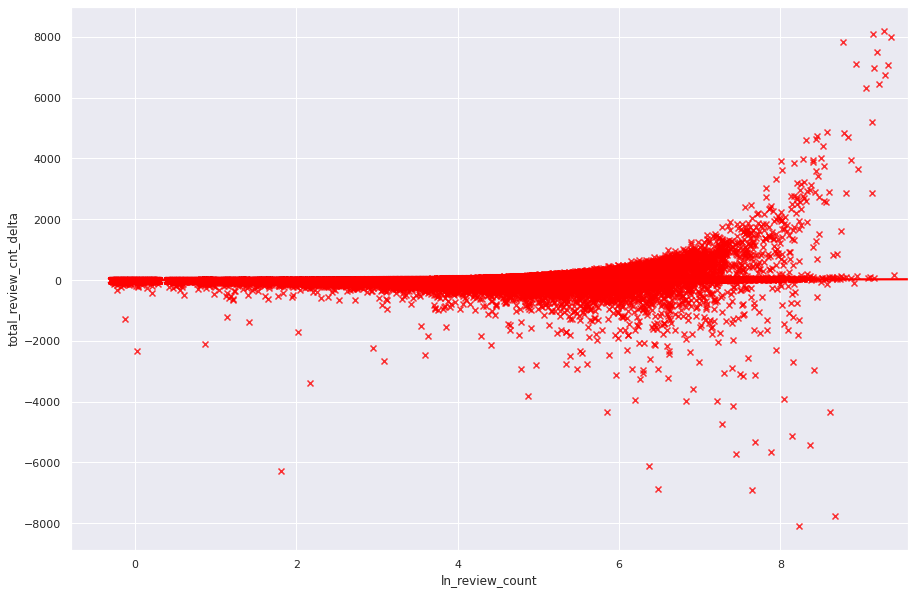

In [43]:
sns.set_theme()
plt.figure(figsize=(15, 10))
sns.regplot(y=most_recent_bh_df_sin_cero['total_review_cnt_delta'], 
x=most_recent_bh_df_sin_cero['ln_review_count'], x_jitter=.30,
color='red', marker='x', lowess=True)

This time we can see that the fit of the regression is pretty bad and this is most likely cause by the extreme values we left in the data.\
Nonetheless with an equation in the form $$y^E = -46.7120 + 15.4866(x)$$ (level - log) 
when ln(x) = 0 or one review then the expected change in reviews over the observed time period is -46.7120. But for an additional percent increase in `ln_review_count` we can expect an increase in the `total_review_cnt_delta`of $$15.4866/100$$.\
Practically speaking with a 10 percent increase in `ln_review_count` which corresponds to .10 difference in log units (e.g. 1.0 -> 1.1) then the `total_review_cnt_delta` would increase by 1.54866 units/review counts over the observed period.

Finally we'll take a look at `ReviewCount` on `BusinessRating`.

<AxesSubplot:xlabel='BusinessRating', ylabel='ReviewCount'>

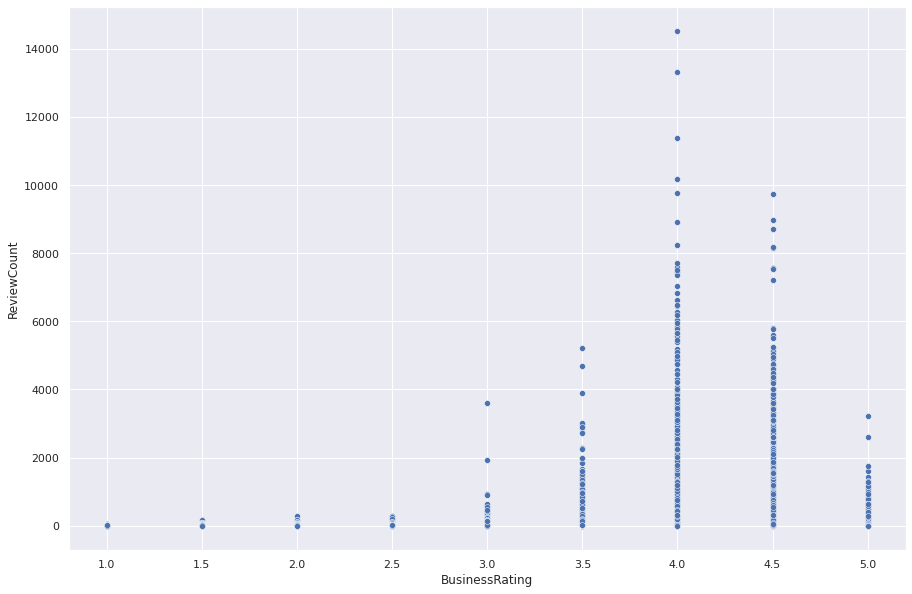

In [53]:
sns.set_theme()
plt.figure(figsize=(15, 10))
sns.scatterplot(x=most_recent_bh_df_sin_cero['BusinessRating'], 
y=most_recent_bh_df_sin_cero['ReviewCount'], x_jitter=.30)

This seems like a really good opportunity to take a higher-order form of our explanatory variable and we'll continue to keep `ReviewCount` as a natural log.

In [54]:
most_recent_bh_df_sin_cero.loc[:, 'BusinessRating_squared'] = most_recent_bh_df_sin_cero.loc[:, 'BusinessRating'] ** 2


/mnt/c/Users/Ron/git-repos/data-analysis-business-economics-policy/da_venv/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [55]:
X_br_brsquared = most_recent_bh_df_sin_cero.loc[:, ['BusinessRating_squared', 'BusinessRating']]
X_br_brsquared_with_constant = sm.add_constant(X_br_brsquared)
y
univariate_lin_model_rc_br = sm.OLS(y, X_br_brsquared_with_constant)
univariate_lin_model_rc_br_results = univariate_lin_model_rc_br.fit(cov_type='HC1')

/mnt/c/Users/Ron/git-repos/data-analysis-business-economics-policy/da_venv/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [56]:
univariate_lin_model_rc_br_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        ln_review_count   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     6495.
Date:                Mon, 28 Feb 2022   Prob (F-statistic):               0.00
Time:                        11:39:04   Log-Likelihood:            -1.2278e+05
No. Observations:               63311   AIC:                         2.456e+05
Df Residuals:                   63308   BIC:                         2.456e+05
Df Model:                           2                                         
Covariance Type:                  HC1                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -4.2649      0.067    -63.984      0.000      -4.396      -4.134
BusinessRating_squared    -0.5754      0.006    -93.475      0.000      -0.587      -0.563
BusinessRating             4.2704      0.041    103.261      0.000       4.189       4.351
==============================================================================
Omnibus:                      941.719   Durbin-Watson:                   1.693
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              595.869
Skew:                           0.091   Prob(JB):                    4.06e-130
Kurtosis:                       2.561   Cond. No.                         240.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

A 12% $$r^2$$ isn't too bad in our case since we are looking to focus on the association more than anything. Let's see what it would have been without the higher-order polynomial specification..

In [57]:
X_br = most_recent_bh_df_sin_cero.loc[:, 'BusinessRating']
X_br_with_constant = sm.add_constant(X_br)
y
univariate_lin_model_rc_br1 = sm.OLS(y, X_br_with_constant)
univariate_lin_model_rc_br1_results = univariate_lin_model_rc_br1.fit(cov_type='HC1')
univariate_lin_model_rc_br1_results.summary()

/mnt/c/Users/Ron/git-repos/data-analysis-business-economics-policy/da_venv/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        ln_review_count   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     1491.
Date:                Mon, 28 Feb 2022   Prob (F-statistic):          1.63e-322
Time:                        11:43:15   Log-Likelihood:            -1.2639e+05
No. Observations:               63311   AIC:                         2.528e+05
Df Residuals:                   63309   BIC:                         2.528e+05
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.9702      0.032     62.391      0.000       1.908       2.032
BusinessRating     0.3197      0.008     38.620      0.000       0.303       0.336
==============================================================================
Omnibus:                     1102.330   Durbin-Watson:                   1.647
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              620.867
Skew:                           0.031   Prob(JB):                    1.51e-135
Kurtosis:                       2.519   Cond. No.                         20.8
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

Text(0.5, 1.0, 'higher-order polynomial of explanatory variable')

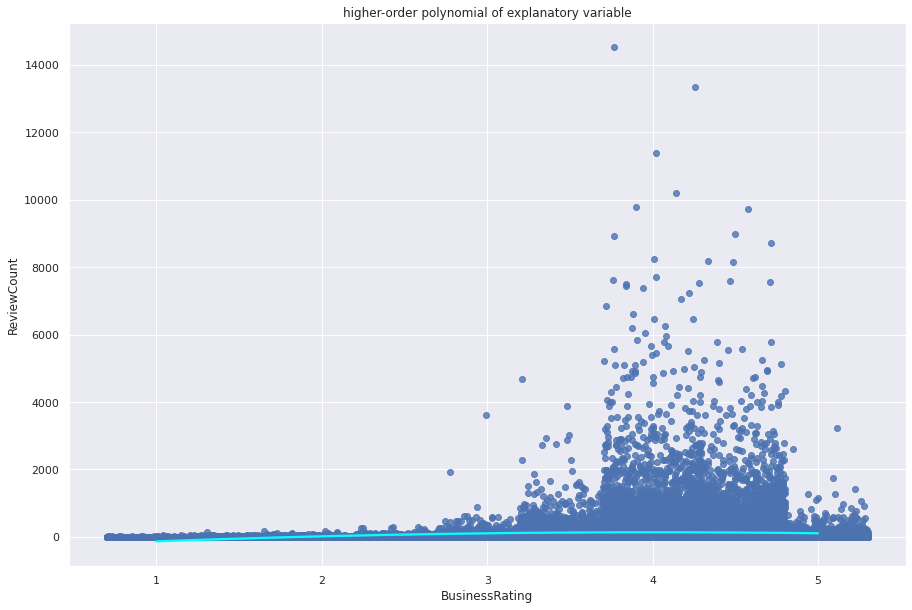

In [63]:
sns.set_theme()
plt.figure(figsize=(15, 10))
sns.regplot(
    x=most_recent_bh_df_sin_cero['BusinessRating'],
    y=most_recent_bh_df_sin_cero['ReviewCount'], x_jitter=.30, order=2,
    line_kws={'color':'cyan'})

plt.title('higher-order polynomial of explanatory variable')

So adding the higher-order polynomial really does help in getting a better fit of the data. The negative coefficient in the square turns the parabola into a concave shape which is mimicing what we see in the data.

> perhaps think about weights in data